Una empresa de transporte quiere monitorear la actividad de sus conductores durante el manejo. Para ello se propone implementar un detector de somnolencia en tiempo real tomando como datos de entrada frames provenientes de una cámara que apunta al rostro del conductor.

1. Emplementar un detector Haar de caras (vista frontal)
2. En esa ROI detectar los ojos (se puede usar otro detector Haar)
3. Mediante alguna de las técnicas vistas en clase, detectar si ambos ojos están abiertos o cerrados y mostrar el estado de la detección sobre el frame.

In [1]:
import cv2 as cv
import numpy as np

### Abrimos la cámara y capturamos video
captura = cv.VideoCapture(0)

while (captura.isOpened()):
    ret, frame = captura.read()

    cv.imshow('webCam',frame)
    if (cv.waitKey(1) == ord('s')):
        break
captura.release()
cv.destroyAllWindows()

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# Leemos los clasificadores pre-entrenados
#--------------------------------------------------------------------------------
face_cascade = cv.CascadeClassifier("haarcascade_frontalface_alt.xml")
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')
captura = cv.VideoCapture(0)

[[27 43 51 51]
 [95 41 52 52]]


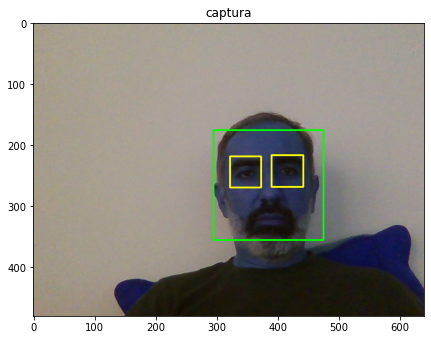

In [6]:
# take first frame of the video
ret,frame = captura.read()

# setup initial location of window
# r,h,c,w - region of image
#           simply hardcoded the values
#r,h,c,w = 240,320,300,300  ## r = posición y de la ROI ; h = altura del ROI ; c = posición x de la ROI ; w = ancho de la ROI
#track_window = (c,r,w,h)

# Pasamos la imagen a escala de grises
#-------------------------------------
grayImage = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
grayImage = cv.equalizeHist(grayImage)
# Llamamos al clasificador de Haar (AdaBoost)
#--------------------------------------------
#faces = face_cascade.detectMultiScale(grayImage, 1.012, 5)
faces = face_cascade.detectMultiScale(grayImage, 1.1, 1)#, minSize= (100,130),maxSize=(200,400))
# Recorro las caras encontradas
#------------------------------

for (x,y,w,h) in faces:
    track_window = (x,y,w,h)
    # Le dibujamos un rectángulo amarillo
    cv.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    # Definimos las ROIs en la imagen gris y color
    roi_gray = grayImage[y:y+h, x:x+w] 
    roi_color = frame[y:y+h, x:x+w] 
    # Para cada rostro hallado le buscamos los ojos
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.06, 8,minSize= (35,35))#,maxSize=(80,100))
    # En los ojos hallados les dibujamos rectángulos
    for (ex,ey,ew,eh) in eyes:
        cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(255,255,0),2)
    print(eyes)

figura = plt.figure(figsize = (7,7))
ax = figura.add_subplot(1, 1, 1)
ax.imshow(frame)
ax.set_title('captura')
        
# set up the ROI for  face tracking
hsv_roi =  cv.cvtColor(frame, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((110., 90.,90.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# set up the ROI for eyes tracking
hsv_roi =  cv.cvtColor(frame, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((110., 90.,90.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)


# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = captura.read()
   
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv.meanShift(dst, track_window, term_crit)

        # Draw it on image      
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), (0,250,0),2)
        cv.imshow('img2',img2)

        k = cv.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv.destroyAllWindows()
captura.release()
    
#figura = plt.figure(figsize = (15,15))
#ax = figura.add_subplot(1, 1, 1)
#ax.imshow(frame,cmap='gray')
#ax.set_title('captura')

#captura.release()
#cv.destroyAllWindows()